In [58]:
# Imports und Setup
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from torch.nn.utils.rnn import pad_sequence

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Using device: cpu


In [59]:
# Daten laden

embedding_dict = np.load("data/embedding_data/weekly_embeddings_dict.npy", allow_pickle=True).item()
embedding_dim = next(iter(embedding_dict.values())).shape[1]

# Zielwerte vorbereiten
tsla = pd.read_csv("data/TSLA_weekly_adjusted.csv", parse_dates=["date"])
tsla = tsla.sort_values("date").reset_index(drop=True)
tsla["target"] = tsla["close"].shift(-1)
tsla["price"] = tsla["close"]
tsla = tsla.dropna()
tsla["week"] = tsla["date"].dt.strftime("%Y-%m-%d")

valid_weeks = set(embedding_dict.keys())
filtered = tsla[tsla["week"].isin(valid_weeks)].reset_index(drop=True)

week_list   = filtered["week"].tolist()
price_list  = filtered["price"].tolist()
target_list = filtered["target"].tolist()


In [60]:
class WeeklyEmbeddingDataset(Dataset):
    def __init__(self, week_list, price_list, target_list, embedding_dict):
        self.week_list     = week_list
        self.price_list    = price_list
        self.target_list   = target_list
        self.embedding_dict = embedding_dict

    def __len__(self):
        return len(self.week_list)

    def __getitem__(self, idx):
        week       = self.week_list[idx]
        emb        = torch.tensor(self.embedding_dict[week], dtype=torch.float32)  # (seq_len, 1027)
        length     = emb.size(0)
        price      = torch.tensor(self.price_list[idx], dtype=torch.float32).unsqueeze(0)  # (1,)
        target     = torch.tensor(self.target_list[idx], dtype=torch.float32)             # ()

        return emb, length, price, target

def collate_fn(batch):
    embs, lengths, prices, targets = zip(*batch)

    padded_embs = pad_sequence(embs, batch_first=True)            # (B, L_max, 1027)
    lengths     = torch.tensor(lengths, dtype=torch.long)        # (B,)
    prices      = torch.stack(prices)                            # (B, 1)
    targets     = torch.tensor(targets, dtype=torch.float32)     # (B,)

    return padded_embs, lengths, prices, targets


In [61]:
# LSTM Modell 

class LSTMWithPrice(nn.Module):
    def __init__(self, input_dim=embedding_dim, hidden_dim=128, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        # nach Concat haben wir hidden_dim + 1 Features
        self.fc = nn.Linear(hidden_dim + 1, 1)

    def forward(self, x, lengths, price):
        # x: (B, L, input_dim), lengths: (B,), price: (B,1)
        packed = nn.utils.rnn.pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        _, (hn, _) = self.lstm(packed)
        h_cat = torch.cat([hn[-1], price], dim=1)
        return self.fc(h_cat).squeeze(1)


In [62]:
# Split train/test nach Zeit (80/20)

# 1) Chronologischer 80/20 Split
sorted_weeks = sorted(week_list)
split_index = int(len(sorted_weeks) * 0.8)

train_weeks = sorted_weeks[:split_index]
test_weeks  = sorted_weeks[split_index:]

# Erzeuge parallel zu den Wochen die Prices und Targets
train_prices = [price_list[week_list.index(w)] for w in train_weeks]
test_prices  = [price_list[week_list.index(w)] for w in test_weeks]

train_targets = [target_list[week_list.index(w)] for w in train_weeks]
test_targets  = [target_list[week_list.index(w)] for w in test_weeks]

# 2) Dataset‑Objekte mit allen vier Argumenten
train_dataset = WeeklyEmbeddingDataset( week_list=train_weeks, price_list=train_prices, target_list=train_targets, embedding_dict=embedding_dict)
test_dataset = WeeklyEmbeddingDataset(week_list=test_weeks, price_list=test_prices, target_list=test_targets, embedding_dict=embedding_dict)

# 3) DataLoader mit dem neuen collate_fn
train_loader = DataLoader( train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)


In [63]:
# Training mit Early Stopping

model = LSTMWithPrice(input_dim=embedding_dim, hidden_dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Early Stopping Parameter
best_val = float('inf')
no_improve   = 0
patience = 5
n_epochs = 50

for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for embs, lengths, prices, targets in train_loader:
        embs, lengths, prices, targets = embs.to(device), lengths.to(device), prices.to(device), targets.to(device)
        optimizer.zero_grad()
        preds = model(embs, lengths, prices)
        loss  = criterion(preds, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * embs.size(0)
    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for embs, lengths, prices, targets in test_loader:
            embs, lengths, prices, targets = embs.to(device), lengths.to(device), prices.to(device), targets.to(device)
            preds = model(embs, lengths, prices)
            val_loss += criterion(preds, targets).item() * embs.size(0)
    val_loss /= len(test_loader.dataset)

    print(f"Epoch {epoch}/{n_epochs} — Train Loss: {train_loss:.4f}  |  Val Loss: {val_loss:.4f}")

    # Early Stopping
    if val_loss < best_val:
        best_val = val_loss
        no_improve = 0
        os.makedirs("models", exist_ok=True)
        torch.save(model.state_dict(), "models/best_model.pth")
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping.")
            break

Epoch 0/50 — Train Loss: 255963.0570  |  Val Loss: 47715.2128
Epoch 1/50 — Train Loss: 228578.5677  |  Val Loss: 41646.7864
Epoch 2/50 — Train Loss: 204822.9450  |  Val Loss: 36423.4700
Epoch 3/50 — Train Loss: 183193.7602  |  Val Loss: 31537.5401
Epoch 4/50 — Train Loss: 163268.0266  |  Val Loss: 27356.2371
Epoch 5/50 — Train Loss: 145490.7511  |  Val Loss: 23358.3746
Epoch 6/50 — Train Loss: 129161.7198  |  Val Loss: 20028.3297
Epoch 7/50 — Train Loss: 114687.0181  |  Val Loss: 17001.5949
Epoch 8/50 — Train Loss: 101204.1174  |  Val Loss: 14391.5642
Epoch 9/50 — Train Loss: 89680.4492  |  Val Loss: 11917.3249
Epoch 10/50 — Train Loss: 78944.4222  |  Val Loss: 9962.3804
Epoch 11/50 — Train Loss: 69635.5608  |  Val Loss: 8195.7642
Epoch 12/50 — Train Loss: 61301.6629  |  Val Loss: 6697.4537
Epoch 13/50 — Train Loss: 53941.4511  |  Val Loss: 5403.4142
Epoch 14/50 — Train Loss: 47476.5852  |  Val Loss: 4321.0670
Epoch 15/50 — Train Loss: 41815.8239  |  Val Loss: 3448.3215
Epoch 16/50 — T

📊 Evaluationsergebnisse:
MSE:  788.3489
MAE:  23.5889
R²:   0.8055


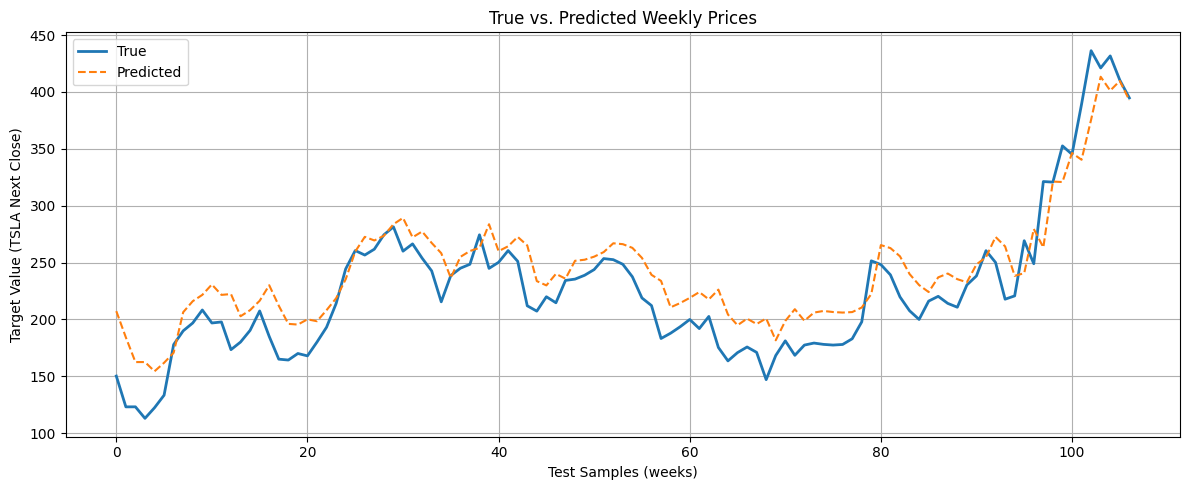

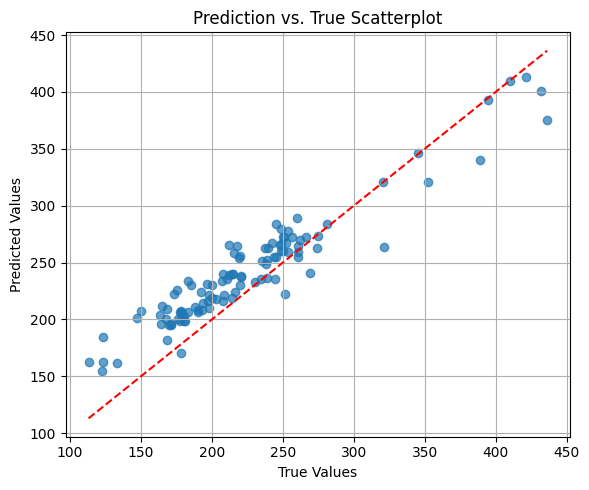

In [ ]:
# Evaluation

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for embeddings, lengths, prices, targets in test_loader:
        embeddings = embeddings.to(device)
        lengths    = lengths.to(device)
        prices     = prices.to(device)
        targets    = targets.to(device)

        outputs = model(embeddings, lengths, prices).squeeze()

        all_preds.extend(outputs.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# In NumPy konvertieren
y_true = np.array(all_targets)
y_pred = np.array(all_preds)

# Metriken berechnen
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2  = r2_score(y_true, y_pred)

print("Evaluationsergebnisse:")
print(f"MSE:  {mse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")

# Plot: Vorhergesagte vs. echte Werte
plt.figure(figsize=(12, 5))
plt.plot(y_true, label='True', linewidth=2)
plt.plot(y_pred, label='Predicted', linestyle='--')
plt.title("True vs. Predicted Weekly Prices")
plt.xlabel("Test Samples (weeks)")
plt.ylabel("Target Value (TSLA Next Close)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatterplot zur Fehleranalyse
plt.figure(figsize=(6, 5))
plt.scatter(y_true, y_pred, alpha=0.7)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Prediction vs. True Scatterplot")
plt.grid(True)
plt.tight_layout()
plt.show()